In [1]:
from helloga.environment import Environment
from helloga.individual import IntegerIndividual
from helloga.crossover import MultiPointCrossOver
from helloga.selector import LeadingSelector
from helloga.fitness import WeightedSumFitness
import logging 
import numpy as np

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from icecream import ic

# GCP: Graph Coloring Problem
- We know the graph structure with all vertices and edges. No weight is necessary in this problem. 
- The vertices connected by 1 edge cannot be the same color. 
- Solve: minimum number of different colors. The coloring result

In [3]:
m = [
    [0,1,1,0,0],
    [1,0,1,1,0],
    [1,1,0,1,0],
    [0,1,1,0,1],
    [0,0,0,1,0],
]
# Set up a distance matrix. For visualization only!
m = np.array(m)
ic(m)


ic| m: array([[0, 1, 1, 0, 0],
              [1, 0, 1, 1, 0],
              [1, 1, 0, 1, 0],
              [0, 1, 1, 0, 1],
              [0, 0, 0, 1, 0]])


array([[0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 1, 0],
       [0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0]])

In [4]:
# create a graph and plot. For visualization only!
g = nx.from_numpy_matrix(m)


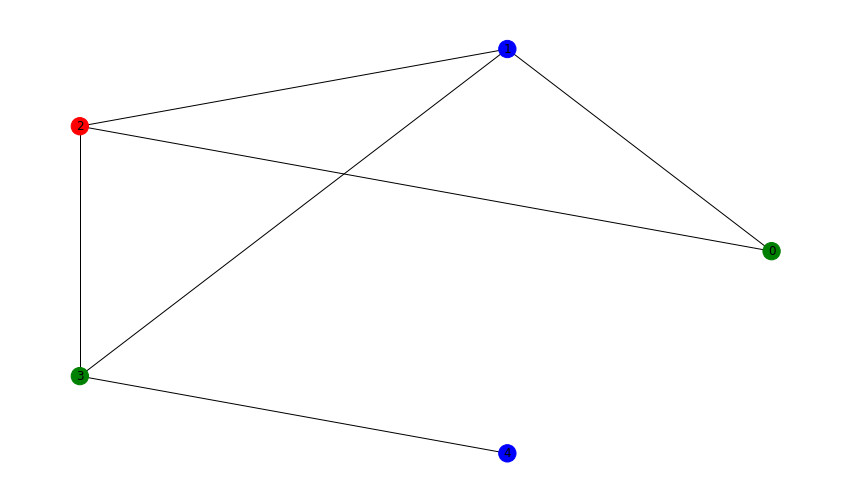

In [5]:
# for xi, yj in zip(x,y) :
#     g.add_edge(xi,yj, weight=m[xi,yj], color='black')
sg = g.subgraph(list(range(5)))
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")

# edgewidth=[]
# for u,v,d in g.edges(data=True):
#     edgewidth.append(round(g.get_edge_data(u,v)['weight']*1,2))
cmap = ['g','b','r','y','w','grey']
plot_options = {"node_size": 300, "with_labels": True, "node_color" : [cmap[i] for i in [0,1,2,0,1]] }
nx.draw_networkx(sg, pos=nx.circular_layout(sg), ax=ax, **plot_options)

# Formulate the Problem
Assume we have 5 nodes to be coloring and infinite number of candidate colors, represented by integer for each color. 

Define the chromosome as a integer vector to represent color of each node, we need at most N(number of nodes) colors in total. The problem is to find out a vector that minimize N where colors at two nodes on the ends of an edge cannot be the same.   
$$ \min \sum_{i}{x_{i}} \quad where \quad i \in \{0, \dots, 4\}  $$
$$ s.t. \quad x_{i} \ne y_{i} \quad where \quad m_{xy} = 1, \quad m \quad is \quad contijency \quad matrix $$


# Define the algorithm
## Intial parameters 
1. Chromosome: integer vector of size 5, each of the element is a node in the graph.
## Evolving Operators
1. Fitness: negative sum of chromosome 
3. Constraints: 
4. Survive Ratio: 0.5 means only top 50% of population can be survived for next reproducing iteration.
5. Mutation Rate: 0.1 by default, indicating that there is 10% probablity switch from 1 to 0 or inversed.
5. Crossover: crossover strategy can be customized, SinglePointCrossover is usually proper for binary cases. 


In [6]:
# Define the constraints
def edge_ends_not_equal(individual, M) :

    x, y = np.where(M==1)

    result = True
    for xi, yi in zip(x, y) :
        result = (result and (individual[int(xi)] != individual[int(yi)]))

    return result

In [7]:
# Test the constraints
ind = IntegerIndividual([0,1,2,0,1],0,0,domain=list(range(5)))
edge_ends_not_equal(ind, M=m)

True

# Define Hyperparameters 
- Initial Individuals: randomly initialized individuals will involve more possibility to find the best solution.
- Selection ratio: can be changed to a smaller value to make the algorithm faster and a larger value to keep more candidates. 


# Algorithm Steps
1. Initialize: input parameters and create algorithm instance
1. Calculate fitness: calculate fitness value for every individual
1. Select: keep only the individuals fulfill the constrants
1. Reproduce: generate new individuals by mutation and crossover operator
1. Exit criteria: check if stop criteria is fulfilled. If yes, stop the progress, otherwise repeat from step 2.  

In [8]:
# Create individuals with none of them are feasible, we'll see they can produce feasible and optimal results though. 
individuals = [ 
    # IntegerIndividual([0,1,2,0,1],0,0,domain=list(range(5))),
    # IntegerIndividual([1,0,2,1,0],0,0,domain=list(range(5))),
    IntegerIndividual([1,1,1,1,1],0,0,domain=list(range(5))),
    IntegerIndividual([1,0,3,2,4],0,0,domain=list(range(5))),
    IntegerIndividual([3,4,1,2,1],0,0,domain=list(range(5))),
    IntegerIndividual([1,2,1,2,1],0,0,domain=list(range(5))),
    IntegerIndividual([3,3,1,2,1],0,0,domain=list(range(5))),
    IntegerIndividual([0,0,1,2,1],0,0,domain=list(range(5))),
    IntegerIndividual([0,4,3,2,1],0,0,domain=list(range(5))),
    IntegerIndividual([3,0,0,2,0],0,0,domain=list(range(5))),
]    

In [9]:

# Define selector
sel = LeadingSelector(
    ratio = 0.5,
    constraints = [lambda x: edge_ends_not_equal(x, m)],
    feasible_ratio = 0
)

# Define fitness
fit = WeightedSumFitness(weights=[-1,-1,-1,-1,-1])

# Define crossover operator
# xo = SinglePointCrossOver()
xo = MultiPointCrossOver(2)


In [10]:
# Create environment 
env = Environment(
    individuals, # initial individuals with at least one feasible solution
    selector=sel, 
    crossover=xo, 
    fitness_func=fit,
    MAX_GENERATION=500, # stop criterion by generation(every time crossover op is called, the individual will be added 1 generation)
    CAPACITY=100, # total individuals in the environment could not exceed this number, otherwise cull the population until population is smaller than capacity.
    MAX_ITERATION=10, # stop when the algorithm iterates to max times. 
    CROSSOVER_RATIO=0.6,
    verbose=1, # show log ever step
)


In [11]:
# Run algorithm
env.evolute()

# Show population size and generation in the final state. 
print(env.species.population(), env.species.generations())


2022-11-22 01:06:33,935 - Species - INFO - ITERATION START -- : 0
2022-11-22 01:06:33,937 - Species - DEBUG - FITNESS - top:-4; sum: -62; avg:-7.75; population:8
2022-11-22 01:06:33,937 - Species - DEBUG - PUNISHMENT -- population: 8, diversity:0
2022-11-22 01:06:33,940 - Species - DEBUG - MUTATION -- population: 16; generation: 1
2022-11-22 01:06:33,948 - Species - DEBUG - XOVER -- population: 88; generation: 1
2022-11-22 01:06:33,959 - Species - DEBUG - FEASIBLE -- top:-4; sum: -62; avg:-7.75; population:17
2022-11-22 01:06:33,961 - Species - DEBUG - FITNESS - top:-6; sum: -152; avg:-8.941176470588236; population:17
2022-11-22 01:06:33,963 - Species - DEBUG - SELECTION -- top:-6; sum: -68; avg:-7.555555555555555; population:9
2022-11-22 01:06:33,963 - Species - DEBUG - PUNISHMENT -- population: 9, diversity:0
2022-11-22 01:06:33,965 - Species - DEBUG - MUTATION -- population: 18; generation: 2
2022-11-22 01:06:33,973 - Species - DEBUG - XOVER -- population: 108; generation: 2
2022-11

8596 8


In [12]:
# Find best 3 solutions if any
print('The best 3 solutions are: ')
for sol in env.getSolution(3) :
    print(sol) 


The best 3 solutions are: 
[2, 0, 1, 2, 0]
[2, 0, 1, 2, 0]
[2, 0, 1, 2, 0]


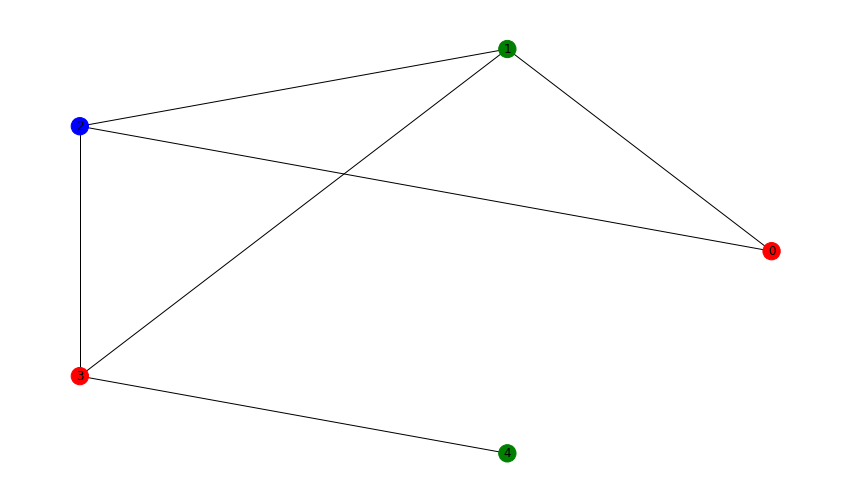

In [13]:
sg = g.subgraph(list(range(5)))
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")

cmap = ['g','b','r','y','w','grey']
node_color = sol.chromosome

plot_options = {"node_size": 300, "with_labels": True, "node_color" : [cmap[i] for i in node_color] }
nx.draw_networkx(sg, pos=nx.circular_layout(sg), ax=ax, **plot_options)